In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from DDIT import DDIT
from statistics import mean
from matplotlib.patches import Rectangle
# ------------------------------------------------------------------------------------------

POP_SIZE = 1000
GENOME_LENGTH = 20
MUTATION_RATE = 1/(2*GENOME_LENGTH) #per site rate
GENERATIONS = 1000
DRIFT_LEN = GENERATIONS//4
sex=True
# ------------------------------------------------------------------------------------------

class Organism:
    def __init__(self,startingFitness = None):
        global GENOME_LENGTH
        self.genome = [random.randint(0,1) for _ in range(GENOME_LENGTH)]
        self.offspringCount = 0
        self.fitness = startingFitness
        
    def make_mutated_copy(self):
        global GENOME_LENGTH, MUTATION_RATE
        self.offspringCount += 1
        child = Organism()
        child.genome = copy.deepcopy(self.genome)
        for i in range(GENOME_LENGTH):
            if random.random() <= MUTATION_RATE:
                PN = random.randint(0,1)
                child.genome[i] += (-1*PN)+(1-PN)
        return child
    
    def __repr__(self,):
        return str(self.fitness)


def fitness(org, on=True):
    if not on:
        return 1
    if not org.fitness:
        org.fitness = eval_sawTooth(sum(org.genome))
#         org.fitness = max( sum(org.genome), 0)
    return org.fitness

def crossover(org1,org2):
    child = Organism()
    child.genome = []
    for i in range(GENOME_LENGTH):
        if random.random() <= 0.5:
            child.genome.append(org1.genome[i])
        else:
            child.genome.append(org2.genome[i])
    return child

def eval_sawTooth(x):
#     x = org.genomeValue #0 is top of first peak
    w = 4 #valley width
    d = 1 #valley depth
    r = 4 #fitness rise peak to peak
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w)) 

def roulette_select(population,batchSize,generation):
    MAX = max([fitness(x,generation%(2*DRIFT_LEN)>=DRIFT_LEN) for x in population])
    F = [np.power(10,fitness(x,generation%(2*DRIFT_LEN)>=DRIFT_LEN)-MAX) for x in population]
#     F = [fitness(x,generation%(2*DRIFT_LEN)>=DRIFT_LEN) for x in population]
    S = sum(F)
    return random.choices(list(range(POP_SIZE)),k=batchSize,weights=[f/S for f in F])


def tournament_select(population,generation,size=2):
#     return max(random.choices(population, k=size),key= lambda x: fitness(x,True))
    return max(random.choices(population, k=size),key= lambda x: fitness(x,generation%(2*DRIFT_LEN)>=DRIFT_LEN))
# ------------------------------------------------------------------------------------------

def KLD(P,Q):
    assert len(P) == len(Q)
    #assumptions: if Q==0, then P==0
    #             if P==0, then p*log(p) := 0
    #             expectation is taken with respect to p
    return sum([p*np.log2(p/q) if p != 0 else 0 for p,q in zip(P,Q)])
#     return sum([p*np.log2(p/q) if p != 0 else 0 for p,q in zip(P,Q) if q != 0]) #more correct?

def KLD_drift(P):
    #assumptions: if Q==0, then P==0
    #             if P==0, then p*log(p) := 0
    #             Q is the theoretical, P is the observed
    Q = [binom.pmf(x, POP_SIZE, 1/POP_SIZE) for x in range(len(P))]
    return sum([p*np.log2(p/q) if p != 0 else 0 for p,q in zip(P,Q)])
        
def VoI(P,Q):
    #variation of information
    from DDIT import DDIT
    ddit = DDIT()
    ddit.register_column_list("P", P)
    ddit.register_column_list("Q", Q)
    ddit.solve_venn_diagram()
    return ddit.entropies["P"] + ddit.entropies["Q"] - 2*ddit.entropies["P:Q"]

def m1(P,DRIFT,generation):
    global DRIFT_LEN
    ddit = DDIT()
    ddit.register_column_list("D", DRIFT)
    ddit.register_column_list("P", P)
#     RETURN = 1-(ddit.H("P") / ddit.H("D"))
    RETURN = 1-(ddit.H("P") / np.log2(len(P)))
    return RETURN

def m2(P,DRIFT,generation):
    return (np.var(P)/(1-(1/len(P))))-1

def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])

In [20]:

from scipy.stats import chisquare
from collections import Counter
from scipy.stats import binom

# Expected = [binom.pmf(x, POP_SIZE, 1/POP_SIZE)*POP_SIZE for x in range(POP_SIZE+1)]
# print("Drift Distribution",list(map(round,Expected[:10])) )
# DRIFTDRIFT = [i for i in Expected for _ in range(round(i))]+[1]

###############
special = [0.7872774193548387, 0.05891612903225806, 0.02669677419354839, 0.017561290322580646, 0.015412903225806452, 0.015129032258064517, 0.01567741935483871, 0.014535483870967742, 0.01315483870967742, 0.010109677419354838, 0.008, 0.005754838709677419, 0.00407741935483871, 0.002632258064516129, 0.0018967741935483871, 0.0012516129032258065, 0.0006387096774193549, 0.0004903225806451613, 0.0002645161290322581, 0.00021935483870967742, 0.00013548387096774193, 9.032258064516129e-05, 1.935483870967742e-05, 3.870967741935484e-05, 6.451612903225806e-06, 6.451612903225806e-06, 6.451612903225806e-06, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


wtfLOG = []

###############

def run():
    population = [Organism() for _ in range(POP_SIZE)]
    KLD_Ds = []
    KLD_Es = []
    scores = []
    offCounts = []
    channelX = []
    channelY = []
    newThing = []

    for generation in range(GENERATIONS):
        print(generation,end="\r")
        if generation >= GENERATIONS//2:
            sex=True
        else:
            sex=False
            
            
        if sex:
            #since organisms always get a +1 to their offspring count when they make a mutated offspring,
            #the binomial distribution changes (as opposed to giving each organism +1/2 an offspring)
            #the interpretation of the binomial is not offspring but gamete contribution
            parents = 2
        else:
            parents = 1
            
         #TOURNAMENT   
        if sex:
            new_population = []
            for _ in range(POP_SIZE):
                p1 = tournament_select(population,generation,size=2).make_mutated_copy()
                p2 = tournament_select(population,generation,size=2).make_mutated_copy()
                new_population.append(crossover(p1,p2))
        else:
            new_population = [tournament_select(population,generation,size=2).make_mutated_copy() for _ in range(POP_SIZE)]


        #ROULETTE
#         if sex:
#             selectedPool = roulette_select(population,2*POP_SIZE,generation)
#             new_population = []
#             for i in range(POP_SIZE):
#                 p1 = population[selectedPool[2*i]].make_mutated_copy()
#                 p2 = population[selectedPool[2*i+1]].make_mutated_copy()
#                 new_population.append(crossover(p1,p2))
            
#         else:
#             new_population = [population[orgNum].make_mutated_copy() for orgNum in roulette_select(population,POP_SIZE,generation)]
        
        
        #moran tournament (ragusa 2022)
        new_population = population[:]
        for batchGen in range(POP_SIZE):
            newOrg = new_population[random.randint(0,POP_SIZE-1)].make_mutated_copy()
            
            #if sex
            if generation >= GENERATIONS//2:
                parent2 = new_population[random.randint(0,POP_SIZE-1)].make_mutated_copy()
                newOrg = crossover(newOrg,parent2)
            
            oldOrg_index = random.randint(0,POP_SIZE-1)

            new_population[oldOrg_index] = max(newOrg,new_population[oldOrg_index],
                                           key=lambda org: fitness(org,generation%(2*DRIFT_LEN)>=DRIFT_LEN))
        
        scores.append([fitness(org) for org in population])
        
        # Kullback-Leibler Divergence https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
        #get offspring counts in a few useful forms
        offCounts.append([org.offspringCount for org in population])
        Counts = Counter(offCounts[-1])
        largest = sorted(Counts.items())[-1][0]
        Observed = [ Counts[x] if x in Counts else 0 for x in range(round(largest)+1)]
        
        #build ideal distributions
#         Drift = Expected[:largest+1] #only includes entries up to observed events
#         Elitism = [POP_SIZE-2]+[1/(POP_SIZE-1) for _ in range(POP_SIZE-1)]+[1] #without zeros
#         Elitism = [POP_SIZE-1]+[0 for _ in range(POP_SIZE-1)]+[1] #with zeros
        
        # compute diference and store
#         KLD_Ds.append(KLD(Observed,Drift))
#         KLD_Es.append(KLD(Observed+[0 for _ in range((POP_SIZE)-largest)],Elitism))
        
#         KLD_Ds.append(KLD(Drift,Observed)) # in theory the proper order for the parameters
#         KLD_Es.append(KLD(Elitism,Observed+[0 for _ in range((POP_SIZE)-largest)]))

#         #hijacked the data storage for a new metric
#         KLD_Ds.append(VoI(Observed,Drift))
#         KLD_Es.append(VoI(Observed+[0 for _ in range((POP_SIZE)-largest)],Elitism))

        #hijacked the data storage for 2 new metrics
#         KLD_Ds.append(m1(offCounts[-1],DRIFTDRIFT,generation))
#         KLD_Ds.append(m2(offCounts[-1],DRIFTDRIFT,generation))

        # new KLD
#         KLD_Ds.append(KLD_drift([x/POP_SIZE for x in Observed]))

        # EMD

         
        KLD_Ds.append(emd([x/POP_SIZE for x in Observed],
                          [binom.pmf(x, parents*POP_SIZE, 1/POP_SIZE) for x in range(largest+1)] ))
        KLD_Es.append(emd([x/POP_SIZE for x in Observed]+[0 for _ in range((parents*POP_SIZE)-largest)],
                          [(POP_SIZE-1)/POP_SIZE]+[0 for _ in range(parents*POP_SIZE-1)]+[1/POP_SIZE]))

#         KLD_Es.append(emd([x/POP_SIZE for x in Observed],[1/(np.e * np.math.factorial(x)) for x in range(largest+1)] ))

#       # blow is a comparison to strong selection as determined by a threshold on the drift  
#         KLD_Es.append(emd([x/POP_SIZE for x in Observed]+[0 for _ in range((POP_SIZE)-largest)],special))
        
        #collect data on strong selection distributions for analysis later
#         if KLD_Ds[-1] > 0.8:
#             wtfLOG.append([x/POP_SIZE for x in Observed]+[0 for _ in range((POP_SIZE)-largest)])
        #------------------------------------------------------------------------------------------------
        # entropy data
        channelX.append([scores[-1].index(max(scores[-1]))]*POP_SIZE) #input is max, sent N times
        Y = []
        for i, org in enumerate(population):
            Y += [i]*org.offspringCount
        channelY.append(Y) #output is actual choices made by selection
        #------------------------------------------------------------------------------------------------
        #new thing
#         newThing.append( ( sum([c/largest for c in Counts.values()]) - 1) / (POP_SIZE-1) )
        #equivelant to above
        newThing.append( ((POP_SIZE/largest)-1) / (POP_SIZE-1) )
        
        population = new_population
    
    return KLD_Ds,KLD_Es,scores,offCounts,channelX,channelY,newThing

# print(Expected)

In [21]:
Xdata = []
Pdata = []
Cdata = []
Odata = []
CXdata = []
CYdata = []
NTdata = []

for i in range(1):
    print(i)
    X,P,C,O,CX,CY,NT = run()
    Xdata.append(X)
    Pdata.append(P)
    Cdata.append(C)
#     maxO = max(map(len,O))
#     Odata.append([o + [0 for _ in range(maxO-len(o))] for o in O])
    Odata.append(O)
    CXdata.append(CX)
    CYdata.append(CY)
    NTdata.append(NT)

Xdata = zip(*Xdata)
Pdata = zip(*Pdata)

###################### average strong selection distribution
thingy = [mean(stuffy) for stuffy in zip(*wtfLOG)]
# print(thingy)

0


In [4]:
# #plot the diference between drift and strong selection
# #if this cell blows up, check that ANY generation had drift >= 0.8
# plt.plot([i*f for i,f in enumerate(np.subtract(thingy,[binom.pmf(x, POP_SIZE, 1/POP_SIZE) for x in range(POP_SIZE+1)])[:50])])
# plt.axhline(0,c="r")
# plt.show()

In [5]:
#class analysis

from statistics import mean,variance
aveC = [mean(x) for x in Cdata[0]]
varC = [variance(x) for x in Cdata[0]]


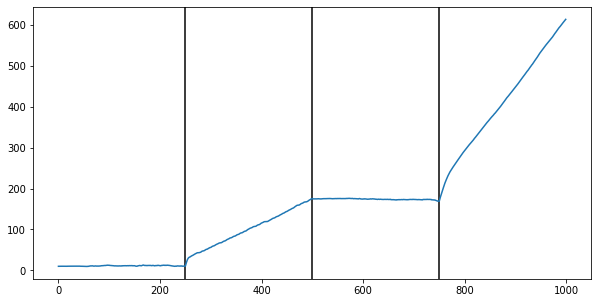

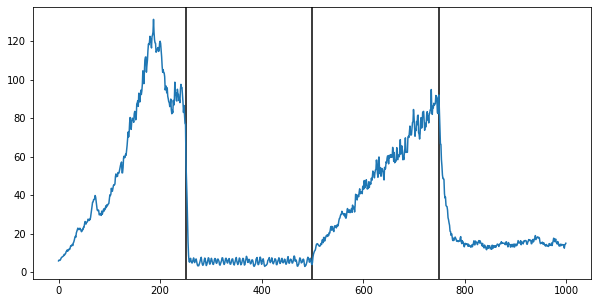

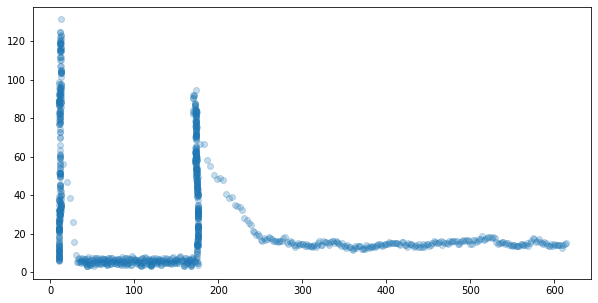

In [6]:
plt.figure(figsize=(10,5))
for i in range(1,GENERATIONS//DRIFT_LEN):
    plt.axvline(i*DRIFT_LEN,color="k")
plt.plot(aveC)
plt.show()

plt.figure(figsize=(10,5))
for i in range(1,GENERATIONS//DRIFT_LEN):
    plt.axvline(i*DRIFT_LEN,color="k")
plt.plot(varC)
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(aveC,varC,alpha=0.25)
plt.show()

In [7]:
aveX = [sum(x)/len(x) for x in Xdata]
aveP = [sum(x)/len(x) for x in Pdata]
# aveXMod = [x/9900 for x in aveX]
# storeX = aveX
# storeP = aveP

In [8]:


driftDataX =[]
selectionDataX=[]
driftDataP =[]
selectionDataP=[]
driftDataC =[]
selectionDataC=[]
driftDataD =[]
selectionDataD=[]


for i in range(GENERATIONS//(2*DRIFT_LEN) +1):
    
    driftDataX.extend(aveX[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataX.extend(aveX[i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])
    
    driftDataP.extend(aveP[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataP.extend(aveP[i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])
    
    driftDataC.extend(varC[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataC.extend(varC[i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])
    
    driftDataD.extend(aveC[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataD.extend(aveC[i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])

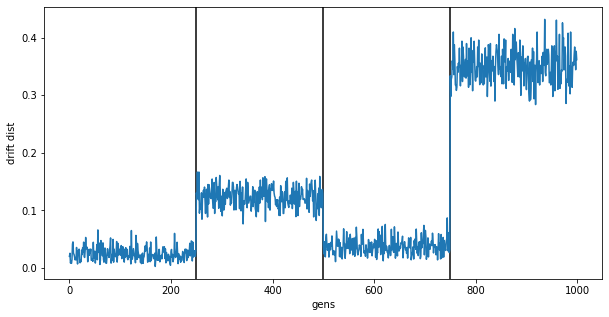

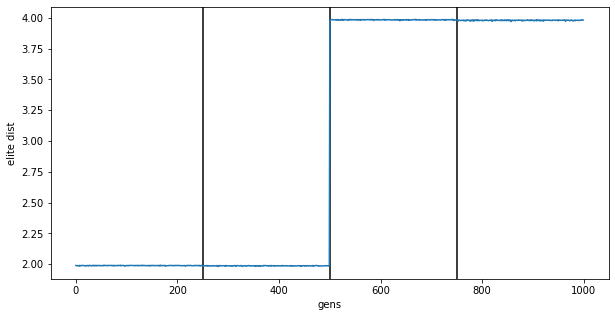

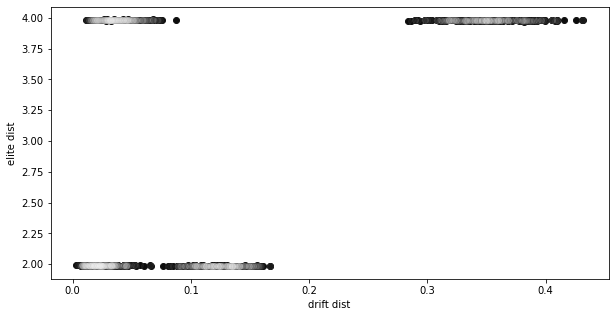

In [9]:

plt.figure(figsize=(10,5))
for i in range(1,GENERATIONS//DRIFT_LEN):
    plt.axvline(i*DRIFT_LEN,color="k")
plt.plot(aveX)#,'o') #drift distance
# plt.axhline(emd([binom.pmf(x, POP_SIZE, 1/POP_SIZE) for x in range(POP_SIZE+1)], [POP_SIZE-1]+[0 for _ in range(POP_SIZE-1)]+[1]),c="r")
plt.ylabel("drift dist")
plt.xlabel("gens")
# plt.ylim(-0.05,0.05)
plt.show()


plt.figure(figsize=(10,5))
for i in range(1,GENERATIONS//DRIFT_LEN):
    plt.axvline(i*DRIFT_LEN,color="k")
plt.plot(aveP) #elitism distance
# plt.axhline(0.05,color="r")
plt.xlabel("gens")
plt.ylabel("elite dist")
plt.show()


plt.figure(figsize=(10,5))
# plt.scatter(storeX,storeP,color="r")
plt.scatter(aveX,aveP,color=(0,0,0)) #drift vs elitism
plt.scatter(aveX,aveP,alpha=0.05,color="w")
# plt.ylim(-0.1,0.05)
# plt.xlim(-0.1,1.3)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("drift dist")
plt.ylabel("elite dist")
plt.show()

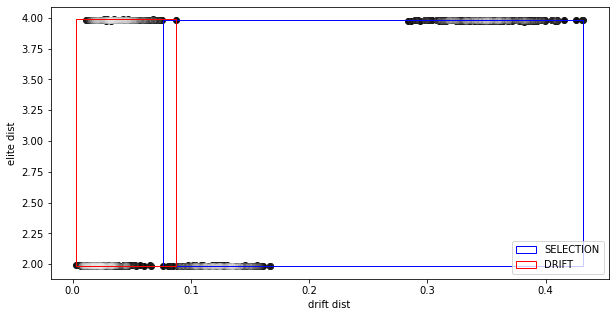

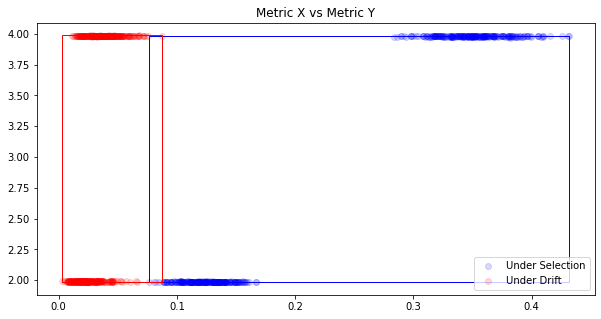

In [10]:
plt.figure(figsize=(10,5))
# plt.scatter(storeX,storeP,color="r")
plt.scatter(aveX,aveP,color=(0,0,0)) #drift vs elitism
plt.scatter(aveX,aveP,alpha=0.05,color="w")
ty = max(selectionDataP)
by = min(selectionDataP)
lx = min(selectionDataX)
rx = max(selectionDataX)

plt.gca().add_patch(
    Rectangle((lx,by),rx-lx,ty-by,
        linewidth=1,edgecolor='b',facecolor='none',label="SELECTION"
    )
)
ty = max(driftDataP)
by = min(driftDataP)
lx = min(driftDataX)
rx = max(driftDataX)

plt.gca().add_patch(
    Rectangle((lx,by),rx-lx,ty-by,
        linewidth=1,edgecolor='r',facecolor='none',label="DRIFT"
    )
)
plt.xlabel("drift dist")
plt.ylabel("elite dist")
plt.legend()
plt.show()

#############################################################################################################

plt.figure(figsize=(10,5))
plt.title("Metric X vs Metric Y")
plt.scatter(selectionDataX,selectionDataP,color=(0,0,1),alpha=0.15,label="Under Selection")

ty = max(selectionDataP)
by = min(selectionDataP)
lx = min(selectionDataX)
rx = max(selectionDataX)

plt.gca().add_patch(
    Rectangle((lx,by),rx-lx,ty-by,
        linewidth=1,edgecolor='b',facecolor='none'
    )
)

plt.scatter(driftDataX,driftDataP,color=(1,0,0),alpha=0.15,label="Under Drift")

ty = max(driftDataP)
by = min(driftDataP)
lx = min(driftDataX)
rx = max(driftDataX)

plt.gca().add_patch(
    Rectangle((lx,by),rx-lx,ty-by,
        linewidth=1,edgecolor='r',facecolor='none'
    )
)

# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

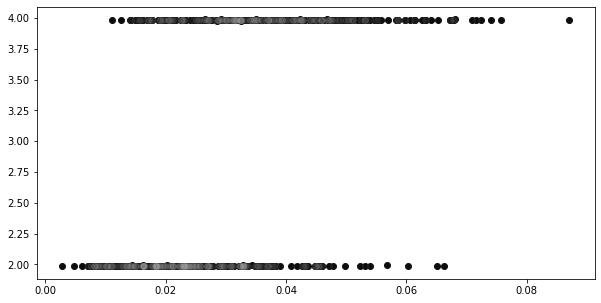

In [11]:
plt.figure(figsize=(10,5))
# plt.scatter(storeX,storeP,color="r")
plt.scatter(driftDataX,driftDataP,color=(0,0,0))
plt.scatter(driftDataX,driftDataP,alpha=0.05,color="w")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

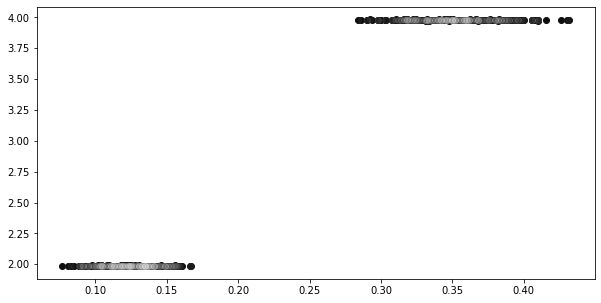

In [12]:
plt.figure(figsize=(10,5))
# plt.scatter(storeX,storeP,color="r")
plt.scatter(selectionDataX,selectionDataP,color=(0,0,0))
plt.scatter(selectionDataX,selectionDataP,alpha=0.05,color="w")
# plt.xscale("log")
# plt.yscale("log")
plt.show()

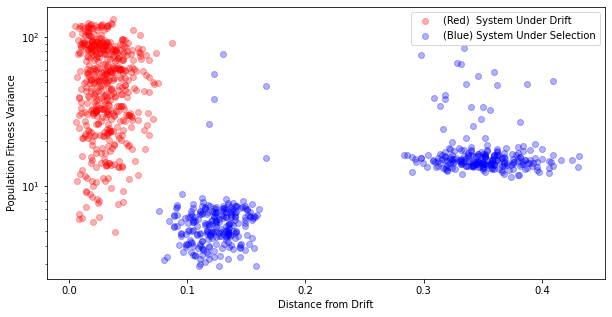

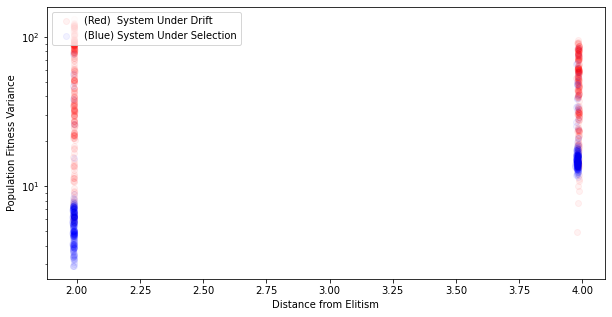

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(driftDataX,driftDataC,alpha=0.3,color="r",label="(Red)  System Under Drift",marker="o")
plt.scatter(selectionDataX,selectionDataC,alpha=0.3,color="b",label="(Blue) System Under Selection",marker="o")
plt.xlabel("Distance from Drift")
plt.ylabel("Population Fitness Variance")
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(driftDataP,driftDataC,alpha=0.05,color="r",label="(Red)  System Under Drift",marker="o")
plt.scatter(selectionDataP,selectionDataC,alpha=0.05,color="b",label="(Blue) System Under Selection",marker="o")
plt.xlabel("Distance from Elitism")
plt.ylabel("Population Fitness Variance")
# plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left")
plt.show()

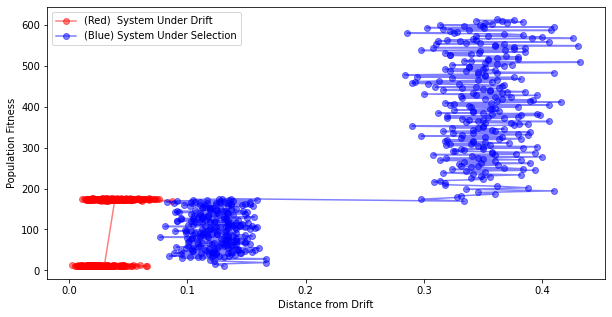

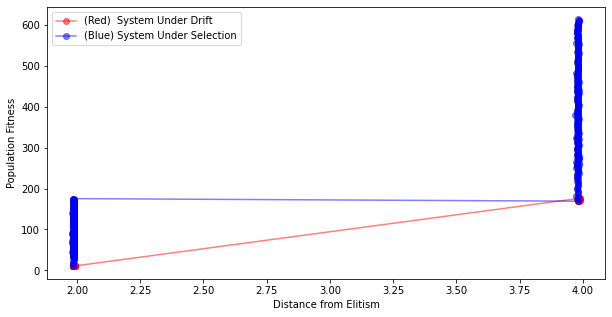

In [14]:
plt.figure(figsize=(10,5))
plt.plot(driftDataX,driftDataD,alpha=0.5,color="r",label="(Red)  System Under Drift",marker="o")
plt.plot(selectionDataX,selectionDataD,alpha=0.5,color="b",label="(Blue) System Under Selection",marker="o")
plt.xlabel("Distance from Drift")
plt.ylabel("Population Fitness")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(driftDataP,driftDataD,alpha=0.5,color="r",label="(Red)  System Under Drift",marker="o")
plt.plot(selectionDataP,selectionDataD,alpha=0.5,color="b",label="(Blue) System Under Selection",marker="o")
plt.xlabel("Distance from Elitism")
plt.ylabel("Population Fitness")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

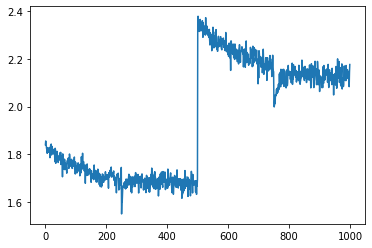

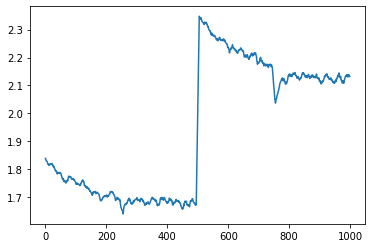

In [15]:
from DDIT import DDIT
ddit = DDIT()

for i,gen in enumerate(Odata[0]):
    ddit.register_column_list("OFF{}".format(i), gen)

for i,gen in enumerate(Cdata[0]):
    ddit.register_column_list("FTN{}".format(i), gen)
    
Hs = []
for i in range(len(Odata[0])):
    Hs.append(ddit.solve_and_return( "OFF{}|FTN{}".format(i,i) ))
    
plt.plot(Hs)
plt.show()

w = 5
# Hs_a = [mean(Hs[j-w//2:j+w//2]) for j in range(0+w//2,len(Hs)-w//2)]
Hs_a = [mean(Hs[max(0,i-w):min(i+w,len(Hs))]) for i in range(len(Hs))]
plt.plot(Hs_a)
plt.show()

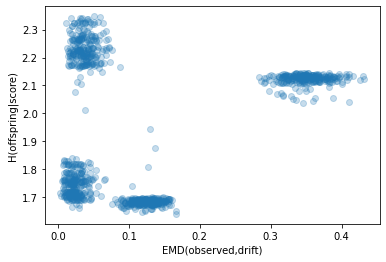

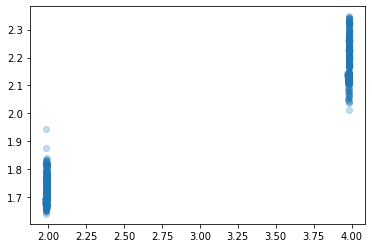

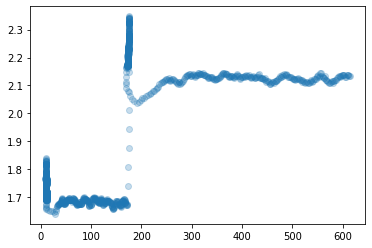

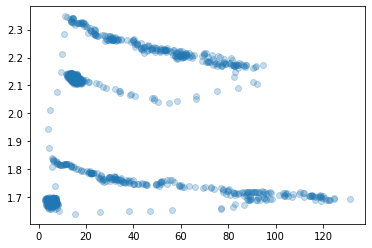

In [16]:
plt.scatter(aveX,Hs_a,alpha=0.25)
plt.xlabel("EMD(observed,drift)")
plt.ylabel("H(offspring|score)")
# plt.xscale("log")
plt.show()

plt.scatter(aveP,Hs_a,alpha=0.25)
# plt.xscale("log")
plt.show()

plt.scatter(aveC,Hs_a,alpha=0.25)
# plt.xscale("log")
plt.show()

plt.scatter(varC,Hs_a,alpha=0.25)
plt.show()

In [17]:
#CX = max * N
#CY = choices made by selection


selectionDataCX = []
selectionDataCY = []

for i in range(GENERATIONS//(2*DRIFT_LEN) +1):
    
#     driftDataX.extend(aveX[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataCX.extend(CXdata[0][i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])
    
#     driftDataP.extend(aveP[i*(2*DRIFT_LEN):i*(2*DRIFT_LEN) + DRIFT_LEN])
    selectionDataCY.extend(CYdata[0][i*(2*DRIFT_LEN)+DRIFT_LEN:i*(2*DRIFT_LEN)+(2*DRIFT_LEN)])

ddit = DDIT()

bigX = []
for gen in selectionDataCX:
    bigX += gen
ddit.register_column_list("X", bigX)

bigY = []
for gen in selectionDataCY:
    bigY += gen
ddit.register_column_list("Y", bigY)
    
# Hs = []
# for i in range(len(Odata[0])):
#     Hs.append(ddit.solve_and_return( "X:Y".format(i,i) ))
    
# plt.plot(Hs)
# plt.show()

ddit.solve_venn_diagram()

AssertionError: 

In [ ]:
plt.plot(NTdata[0]) #(sum(count/largest_count)-1) / pop_size-1 == (N-largest)/(N*largest - largest) ~= 1/largest
plt.show()

plt.scatter(aveX,NTdata[0],alpha=0.25)#drift
# plt.yscale("log")
plt.show()

plt.scatter(aveP,NTdata[0],alpha=0.25)#elitism
# plt.yscale("log")
plt.show()

plt.scatter(aveC,NTdata[0],alpha=0.25)#popAve
# plt.yscale("log")
plt.show()

plt.scatter(varC,NTdata[0],alpha=0.25)#popVar
# plt.yscale("log")
plt.show()

In [ ]:
errorLog = []
maxN = 170
for N in range(1,maxN):
    errorLog.append(emd([binom.pmf(x, N, 1/N) for x in range(maxN+1)],
                 [1/(np.e * np.math.factorial(x)) for x in range(maxN+1)]))
plt.plot(errorLog)
plt.yscale("log")
plt.show()

In [ ]:
N = 10
print(emd(
    [binom.pmf(x, N, 1/N) for x in range(N+1)],
    [c/N for c in [5, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]]
))
print(emd(
    [c/N for c in [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],
    [c/N for c in [5, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0]]
))